# Frequency Domain Analysis

In [982]:
import sys
import os
sys.path.append(os.path.abspath(".."))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [983]:
from utils.libaries import *
from utils.data_loading import findFiles,LoadDataSignals
from utils.global_parameters import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.pan_algorithm import *
from time_of_flight_calculation.zero_crossings import *
from utils.libaries import *
from utils.data_loading import findFiles,LoadDataSignals
from utils.global_parameters import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.pan_algorithm import *
from time_of_flight_calculation.zero_crossings import *
from time_of_flight_calculation.tof import *
from time_of_flight_calculation.velocity import *
from time_of_flight_calculation.sugar_velocity_relationship import *
from time_of_flight_calculation.correlation import *
from plotting_module.crosscorrelation_plot import *


In [984]:
waveforms=["sin","squ"]
periods= ["1","5","9"]

expected_waveform= waveforms[1]
expected_periods= periods[1]

unique_file_list= findFiles(expected_waveform,expected_periods,root_folder,sample_number=1)
unique_file_list

['/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/144000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-144000mg-squ5-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/108000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-108000mg-squ5-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/36000mg/2025may28-ram-WaterSugar_mid_solution-36000mg-squ5-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/00000mg/2025may28-ram-WaterSugar_mid_solution-0mg-squ5-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal p

In [985]:
raw,Concentration,actual_waveform,periods=LoadDataSignals(unique_file_list[2],time_axis_start=0,time_axis_end=16000)

raw.shape


(100, 2, 16000)

In [986]:
transmit, receive= dc_offset_removal(raw)

DC Offset Removal - Transmit: (100, 16000)  | Receive: (100, 16000)


In [987]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

def plot_signal_fft(signal, fs):
    N = len(signal)
    signal=signal* np.hamming(N)
    yf = np.abs(fft(signal))
    xf = fftfreq(N, 1/fs)

    # One-sided spectrum
    plt.plot(xf[:N//2]/1e6, yf[:N//2])
    plt.title("FFT Spectrum")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()


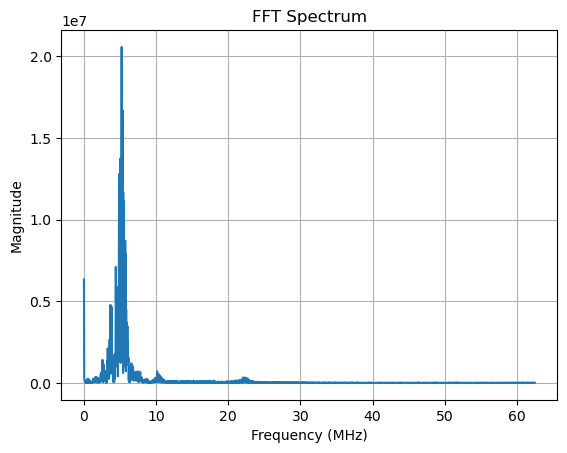

In [988]:
fs = 125e6  # Sampling rate: 125 MHz
plot_signal_fft(receive[0,5000:], fs)


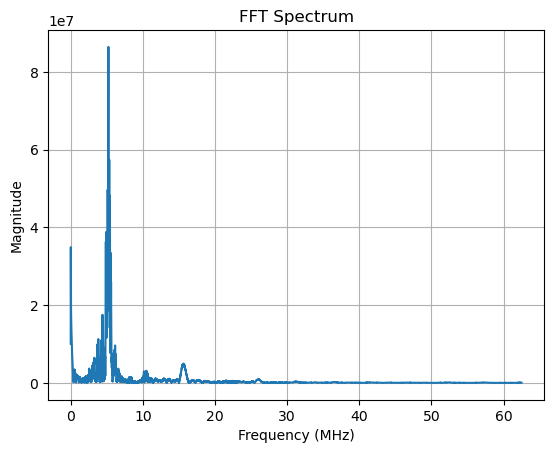

In [989]:
signal=receive[0,:]

<Figure size 1200x600 with 0 Axes>

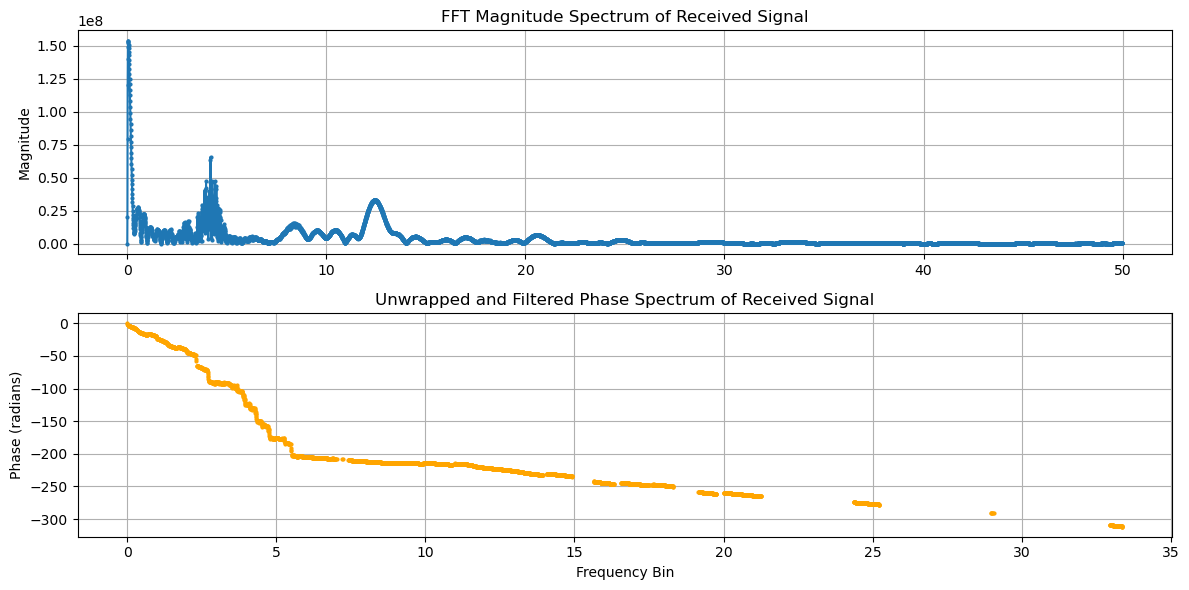

Number of valid phase points: 6242


In [990]:
S = np.fft.fft(signal)
S_mag = np.abs(S)
S_phase = np.angle(S)
threshold = 0.01 * np.max(S_mag)  # 1% of max magnitude
S_phase_clean = np.where(S_mag > threshold, S_phase, np.nan)

half = N // 2


import matplotlib.pyplot as plt
import numpy as np

t = np.arange(len(S))

plt.figure(figsize=(12, 6))

S_phase_unwrapped = np.unwrap(S_phase)
S_phase_unwrapped_clean = np.where(S_mag > threshold, S_phase_unwrapped, np.nan)
fs = 100_000_000  # 100 MHz
N = len(S)
freqs = np.fft.fftfreq(N, d=1/fs)
freqs_MHz = freqs / 1e6


plt.figure(figsize=(12, 6))

# FFT Magnitude
plt.subplot(2, 1, 1)
plt.plot(freqs_MHz[:half], S_mag[:half], 'o-', markersize=2)
plt.title("FFT Magnitude")
plt.ylabel("Magnitude")
plt.title("FFT Magnitude Spectrum of Received Signal")

plt.grid(True)

# FFT Phase (Unwrapped + Clean)
plt.subplot(2, 1, 2)
plt.plot(freqs_MHz[:half], S_phase_unwrapped_clean[:half], 'o-', color='orange', markersize=2)
plt.title("Unwrapped and Filtered Phase Spectrum of Received Signal")
plt.ylabel("Phase (radians)")
plt.xlabel("Frequency Bin")
plt.grid(True)

plt.tight_layout()
plt.show()


print("Number of valid phase points:", np.sum(S_mag > threshold))




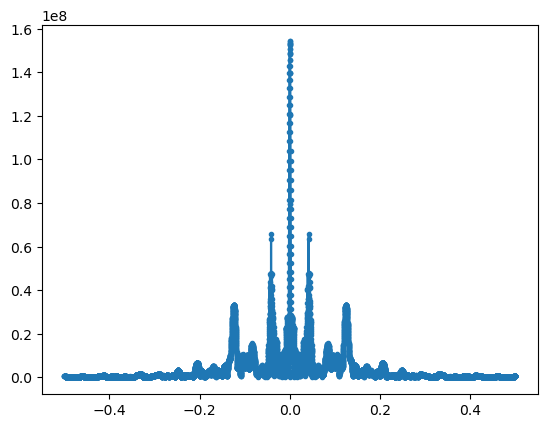

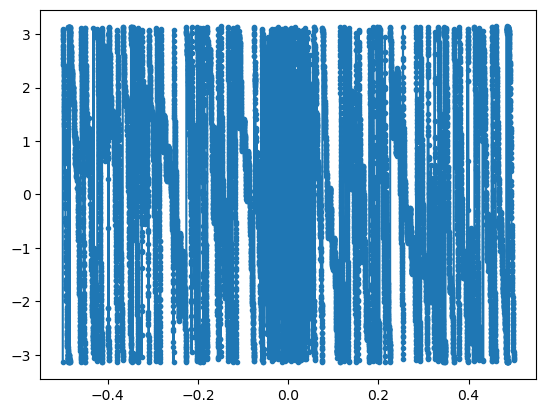

In [991]:
import numpy as np
import matplotlib.pyplot as plt

Fs = 1 # Hz
N = 16000 # number of points to simulate, and our FFT size

t = np.arange(N) # because our sample rate is 1 Hz
s = receive[0,:]
S = np.fft.fftshift(np.fft.fft(s))
S_mag = np.abs(S)
S_phase = np.angle(S)
f = np.arange(Fs/-2, Fs/2, Fs/N)
plt.figure(0)
plt.plot(f, S_mag,'.-')
plt.figure(1)
plt.plot(f, S_phase,'.-')
plt.show()

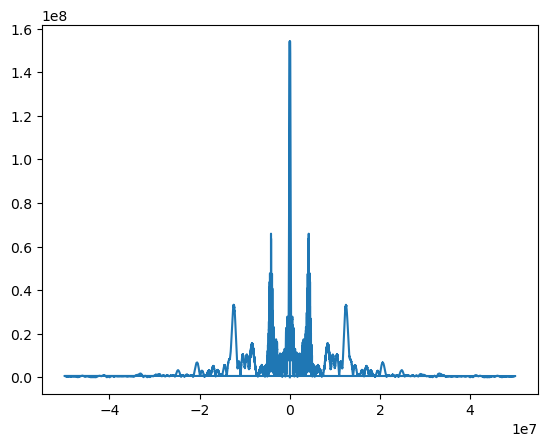

In [992]:
# Without shift
S = np.fft.fft(s)
f = np.fft.fftfreq(len(s), d=1/fs)  # fs is sampling frequency
plt.plot(f, np.abs(S))




(-1000000.0, 1000000.0)

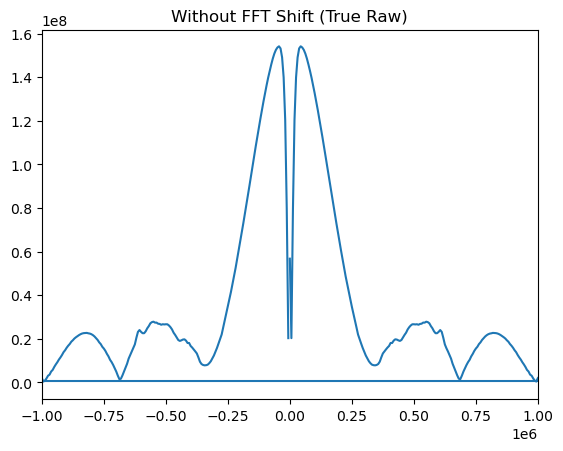

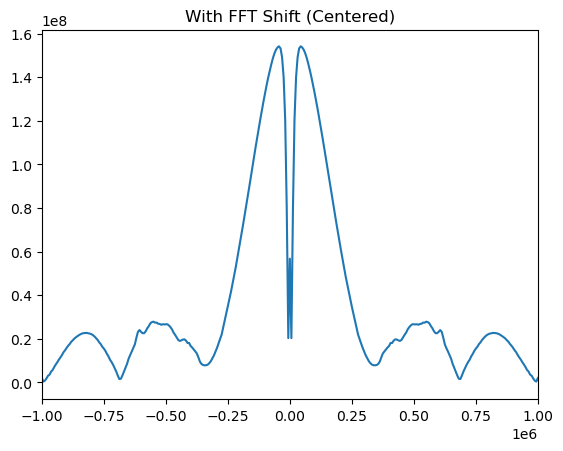

In [993]:
# RAW FFT (no shift)

s=raw[0,1,:]
S1 = np.fft.fft(s)
f1 = np.fft.fftfreq(len(s), d=1/fs)
plt.figure()
plt.plot(f1, np.abs(S1))
plt.title("Without FFT Shift (True Raw)")
plt.xlim(-1e6, 1e6)

# SHIFTED FFT
S2 = np.fft.fftshift(np.fft.fft(s))
f2 = np.fft.fftshift(np.fft.fftfreq(len(s), d=1/fs))
plt.figure()
plt.plot(f2, np.abs(S2))
plt.title("With FFT Shift (Centered)")
plt.xlim(-1e6, 1e6)



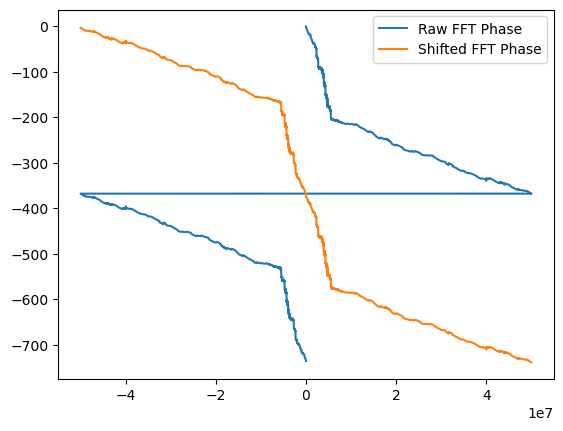

In [994]:
plt.plot(f1, np.unwrap(np.angle(S1)), label="Raw FFT Phase")
plt.plot(f2, np.unwrap(np.angle(S2)), label="Shifted FFT Phase")
plt.legend()


# TOF

In [995]:
from utils.libaries import *
from utils.data_loading import findFiles, LoadDataSignals
from utils.global_parameters import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.pan_algorithm import *
from time_of_flight_calculation.velocity import *
from time_of_flight_calculation.sugar_velocity_relationship import *
from plotting_module.crosscorrelation_plot import *

def calculate_sugar_percentage(sugar_mg, water_quantity_ml):
    return (sugar_mg / water_quantity_ml) * 0.1

def convert_mg_to_percent(velocities, water_quantity_ml):
    converted_velocities = []
    for item in velocities:
        mg_value, velocity = item
        percent_value = calculate_sugar_percentage(mg_value, water_quantity_ml)
        converted_velocities.append([percent_value, velocity])
    return converted_velocities

def get_optimal_fft_size(burst_size, fc, fs, safety_margin=1.5):
    samples_per_cycle = fs / fc
    burst_len = int(burst_size * samples_per_cycle * safety_margin)
    N_fft = 2 ** int(np.ceil(np.log2(burst_len)))
    return N_fft, burst_len

def estimate_tof_phase(tx, rx, fs, f_range):
    N = len(tx)
    window = np.hamming(N)
    tx_win = tx * window
    rx_win = rx * window
    TX = np.fft.fft(tx_win)
    RX = np.fft.fft(rx_win)
    freqs = np.fft.fftfreq(N, 1/fs)

    mask = (freqs > f_range[0]) & (freqs < f_range[1])
    phase_tx = np.angle(TX[mask])
    phase_rx = np.angle(RX[mask])
    dphi = np.unwrap(phase_rx - phase_tx)

    f = freqs[mask]
    slope, _ = np.polyfit(f, dphi, 1)
    tof = -slope / (2 * np.pi)

    print(f"FFT frequency range used: {f[0]/1e6:.2f} MHz to {f[-1]/1e6:.2f} MHz")
    print(f"Center frequency (avg): {np.mean(f)/1e6:.2f} MHz")
    print("Phase TX:", phase_tx, "Phase RX:", phase_rx)
    print("dphi (raw):", phase_rx - phase_tx)
    print("ToF:", tof, "Expected range:", "≈ 20–60 ns")

    return tof

def process_signals1(unique_file_list, burst_size=5, center_frequency=5e6):
    velocities = []
    concentrations = []
    tofs = []
    file_paths = []
    start = 0
    end = 16000

    for file in unique_file_list:
        print("\n\n File Name:", file)
        raw, concentration, actual_waveform, periods = LoadDataSignals(file, time_axis_start=0, time_axis_end=16000)
        print("shape of raw signal: ", raw.shape)
        print("Period: ", periods)
        print("Concentration: ", concentration)

        transmit, receive = dc_offset_removal(raw)
        _receive = receive[0, start:end]
        _transmit = transmit[0, start:end]

        transmit_echo_list, recieve_echo_list, _, _ = apply_pan_algorithm(_transmit, _receive, periods, T, low_cutoff, high_cutoff, order=4, window_size=11, min_prominence=0.05)
        transmit_max_pair = transmit_echo_list[0]
        recieve_max_pair = recieve_echo_list[0]
        t_start_index = transmit_max_pair[0]
        r_start_index = recieve_max_pair[0]

        N_fft, slice_len = get_optimal_fft_size(burst_size, center_frequency, fs=125e6)

        tx_slice = _transmit[t_start_index:t_start_index + slice_len]
        rx_slice = _receive[r_start_index:r_start_index + slice_len]

        tx_slice = np.pad(tx_slice, (0, N_fft - len(tx_slice)), 'constant')
        rx_slice = np.pad(rx_slice, (0, N_fft - len(rx_slice)), 'constant')

        try:
            tof = estimate_tof_phase(tx_slice, rx_slice, fs=125e6, f_range=(3e6, 6.5e6))
            print("Phase-based TOF: ", tof)
        except Exception as e:
            print(f"[ERROR] Phase-based TOF calculation failed: {e}")
            continue

        tofs.append(tof)
        velocity = find_Velocity(tof, distance=0.083)
        velocities.append(velocity)
        concentrations.append(int(concentration))
        print("Velocity: ", velocity)

    zipped_data = list(zip(concentrations, velocities))
    converted_velocity = convert_mg_to_percent(zipped_data, water_quantity)
    time_of_flight = list(zip(concentrations, tofs))

    return converted_velocity, time_of_flight, actual_waveform, [], []

In [996]:

converted_velocity, time_of_flight, actual_waveform, [], []=process_signals1(unique_file_list, burst_size=int(expected_periods), center_frequency=5e6)




 File Name: /Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/144000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-144000mg-squ5-pure_water_solution_1.mat
shape of raw signal:  (100, 2, 16000)
Period:  5
Concentration:  144000
DC Offset Removal - Transmit: (100, 16000)  | Receive: (100, 16000)
Dynamic Start Threshold: 0.5
Dynamic End Threshold: 0.2
Dynamic Start Threshold: 0.01
Dynamic End Threshold: 0.005
Transmit [(2, 116)]
Recieve [(6129, 8884)]
FFT frequency range used: 3.42 MHz to 6.35 MHz
Center frequency (avg): 4.88 MHz
Phase TX: [-2.39805081  1.18173007 -1.47254461  2.69360406  0.80143706 -1.16395873
  2.75999981] Phase RX: [ 2.69696137 -0.72069331  2.4147727   0.03203976 -2.29811726  1.51597544
 -1.40037285]
dphi (raw): [ 5.09501219 -1.90242339  3.8873173  -2.6615643  -3.09955432  2.67993417
 -4.16037266]
ToF: 1.5158902429659349e-07 Expected range: ≈ 20–60 ns
Phase-based TO

In [997]:
converted_velocity

[[8.470588235294118, 547533.0445930259],
 [6.352941176470589, 359252.82300187106],
 [2.1176470588235294, 322028.0356043048],
 [0.0, 330464.39682225283],
 [1.0588235294117647, 322052.75898772705],
 [3.1764705882352944, 352260.3252978242],
 [5.294117647058823, 354283.47323773295],
 [4.235294117647059, 364220.1380419455],
 [7.411764705882354, 353264.23096737015]]

In [1001]:
velocities = sorted(converted_velocity, key=lambda x : x[0])
velocities.pop(-1)

[8.470588235294118, 547533.0445930259]

In [999]:
from plotting_module.signal_veclocity_plot import *

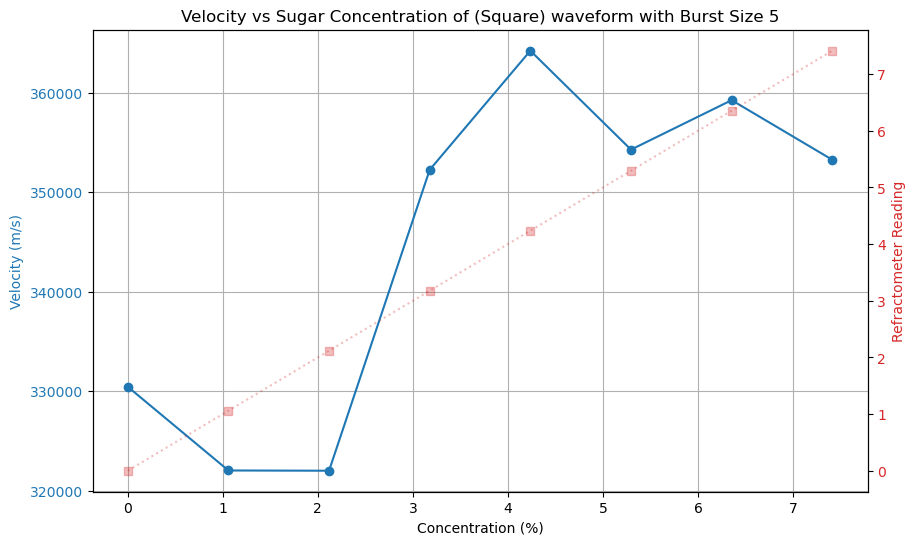

In [1002]:
plot_velocity_refractometer(velocities, expected_periods)

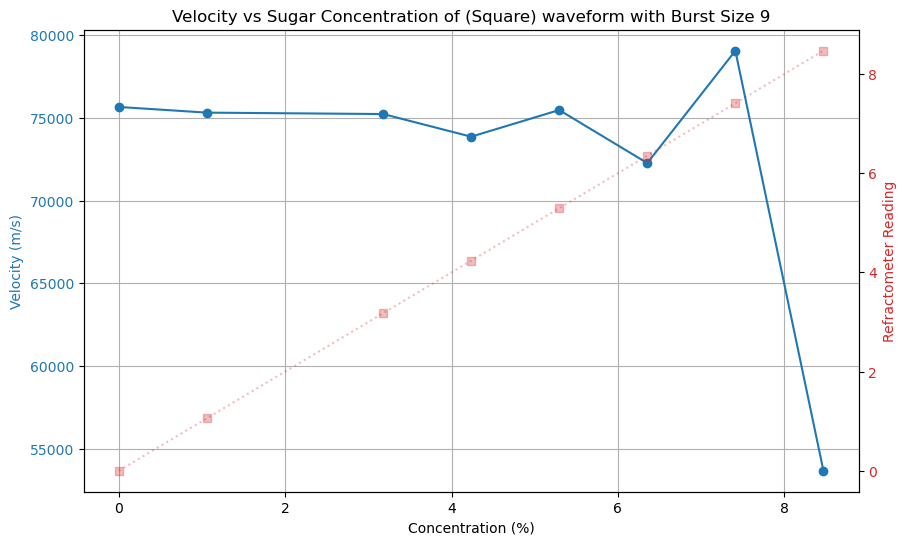